# LSTM 으로 시계열 데이터 예측하기

시계열 데이터는 시간에 따라 변하는 데이터 유형이다. 예를 들어, 24 시간 동안의 온도, 한 달에 다양한 제품의 가격, 1 년 안에 특정 회사의 주가 등을 시계열 데이터라고 할 수 있다.


LSTM ( Long Short Term Memory Networks) 과 같은딥 러닝 모델은 시계열 데이터의 패턴을 캡처 할 수 있으므로 미래 데이터 추세에 대한 예측을 수행하는 데 사용할 수 있다. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch

### flight 데이터 셋
데이터 세트는 세 개의 열이 있다 
* year : 년도
* month : 월
* passengers: 지정된 달의 총 여행 승객 수 

In [2]:
flight_data = pd.read_csv('./data/flight.csv')
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


총 144개월의 비행승객의 정보를 가지고 있다.  
passengers컬럼을 선그래프로 시각화해보자.

In [3]:
flight_data.shape

(144, 3)

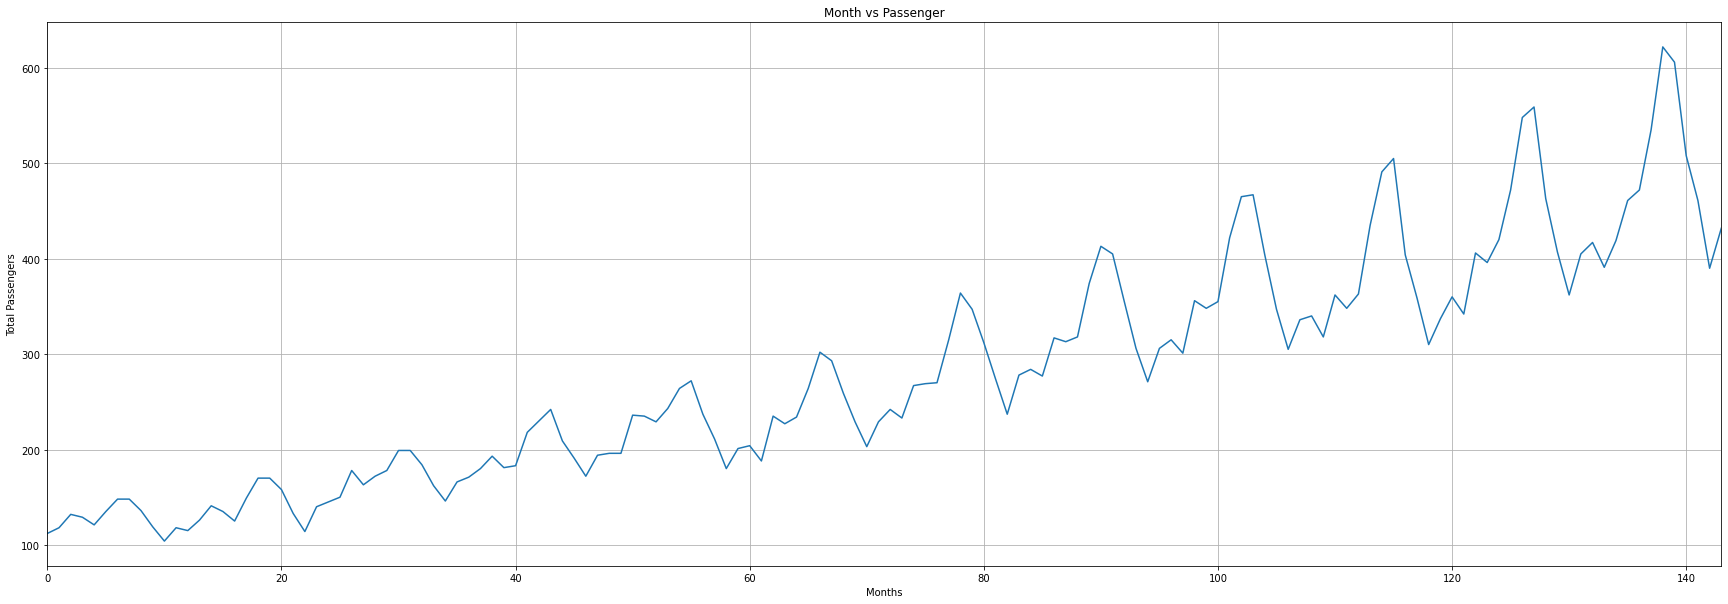

In [4]:
# 월별 해당 승객수의 시각화

plt.figure(figsize=(30,10))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

* 결과는 수년에 걸쳐 비행기로 여행하는 평균 승객 수가 증가했음을 보여준다. 
* 1 년 이내에 여행하는 승객의 수는 변동한다. 이는 여름 또는 겨울 방학 동안 여행 승객의 수가 다른 해에 비해 증가하기 때문에 의미가 있다.

# 시계열 데이터의 예측
총 지난 144 개월의 기록을 가지고 있다. 처음 132 개월을 기준으로 마지막 12 개월 동안 여행 승객의 수를 예측해보자. 처음 132 개월의 데이터가 LSTM 모델을 훈련시키는데 사용되고 마지막 12 개월의 값을 테스트 셋으로 사용하여 모형을 평가한다.

### 데이터 전처리

In [5]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    int64 
 1   month       144 non-null    object
 2   passengers  144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [6]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


### 훈련데이터와 테스트데이터 분리
데이터 세트를 훈련 및 테스트 세트로 나눈다.

In [7]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [8]:
print(len(train_data))
print(len(test_data))

132
12


### 데이터 scale 조정
현재 데이터 세트가 정규화되지 않았다. 초기 몇 년 동안의 총 승객 수는 나중 몇 년 동안의 총 승객 수에 비해 훨씬 적다. 시계열 예측을 위해 데이터의 스케일을 조정한다. 특정 최소값 및 최대 값 범위 내에서 데이터를 정규화하는 데이터 세트에 대해 최소 / 최대 스케일링을 수행한다.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

다음 단계는 PyTorch 모델이 텐서를 사용하여 학습되므로 데이터 세트를 텐서로 변환

In [10]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

### 시퀀스 데이터 생성

데이터 세트에서는 월간 데이터가 있고 1 년에 12 개월이 있으므로 시퀀스 길이 12를 사용하는 것이 편리하다. 
훈련을 위한 입력 시퀀스 길이를 12로 설정한다.

In [11]:
train_window = 12

In [12]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

### create_inout_sequences 함수
이 함수는 원시 입력 데이터를 훈련에 맞도록 시퀀스 데이터로 변환하여 튜플을 리턴한다. 
처음 12 개월 동안 여행하는 승객 수로 13개월의 승객수를 예측한다. 
* 튜플의 첫번째 값: 12개월의 승객수 시퀀스(=features)
* 튜플의 두번째 값: 12개월의 승객수로 예측한 승객수(=target)

In [13]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [14]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

# LSTM 모델 생성


* input_size: 입력 시퀀스의 개수에 해당한다. 시퀀스 길이는 12이지만 매월 1 개의 값, 즉 총 승객 수만 있으므로 입력 크기는 1이다.
* hidden_layer_size: hidden layer의 개수 지정합니다.
* output_size: 출력의 항목 수는 앞으로 1 개월 동안 승객 수를 예측하기 때문에 출력 크기는 1이다.

In [15]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [17]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [18]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


# 모델 훈련

모델을 훈련한다. 원한다면 더 많은 epoch를 시도해 볼 수 있다. loss를 출력한다.

In [19]:
epochs = 300

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.01047638
epoch:  26 loss: 0.00679063
epoch:  51 loss: 0.00415547
epoch:  76 loss: 0.00096320
epoch: 101 loss: 0.00006765
epoch: 126 loss: 0.02425956
epoch: 151 loss: 0.00000612
epoch: 176 loss: 0.00014968
epoch: 201 loss: 0.00043979
epoch: 226 loss: 0.00975290
epoch: 251 loss: 0.00306817
epoch: 276 loss: 0.00014268
epoch: 299 loss: 0.00015401


# 예측하기

테스트 세트에는 지난 12 개월 동안의 승객 데이터가 포함되어 있다. 모델은 시퀀스 길이 12를 사용하여 예측하도록 훈련되어 있다. 마지막 12개월의 데이터를 예측해 보자.

In [20]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


테스트 세트의 12 회 반복 실행된다. 반복이 끝나면 test_inputs목록에 24 개의 항목이 포함된다. 마지막 12 개 항목은 테스트 세트에 대해 예측 된 값이다.

In [21]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [22]:
# 마지막 12 개의 예측값을 확인한다.
test_inputs[fut_pred:]

[0.3611587584018707,
 0.28511759638786316,
 0.45561057329177856,
 0.38738447427749634,
 0.4807637333869934,
 0.5269097685813904,
 0.6968854069709778,
 0.7918510437011719,
 0.8911417722702026,
 0.5640976428985596,
 0.40976253151893616,
 0.28557848930358887]

### inverse_transform
훈련을 위해 데이터 세트를 정규화 했으므로 예측 된 값도 정규화된다. 정규화 된 예측 값을 실제 예측 값으로 변환해야한다. 데이터 세트를 정규화하는 데 사용한 min/max 스케일러 객체의 inverse_transform을 사용하여 원래 값으로 변환한다.

In [23]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[413.66361754]
 [396.36425318]
 [435.15140542]
 [419.6299679 ]
 [440.87374935]
 [451.37197235]
 [490.04143009]
 [511.64611244]
 [534.23475319]
 [459.83221376]
 [424.72097592]
 [396.46910632]]


In [24]:
# 변환된 값을 출력한다.
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


## 결과 시각화하기

LSTM의 예측은 주황색 선으로 표시된다. 결과가 정확하지는 않지만  지난 12 개월 동안 여행하는 총 승객 수의 변동에 따라 상승 추세를 파악할 수는 있다. LSTM 계층에서 더 많은 수의 에포크와 더 많은 수의 뉴런을 사용하여 더 나은 성능을 얻을 수 있다.

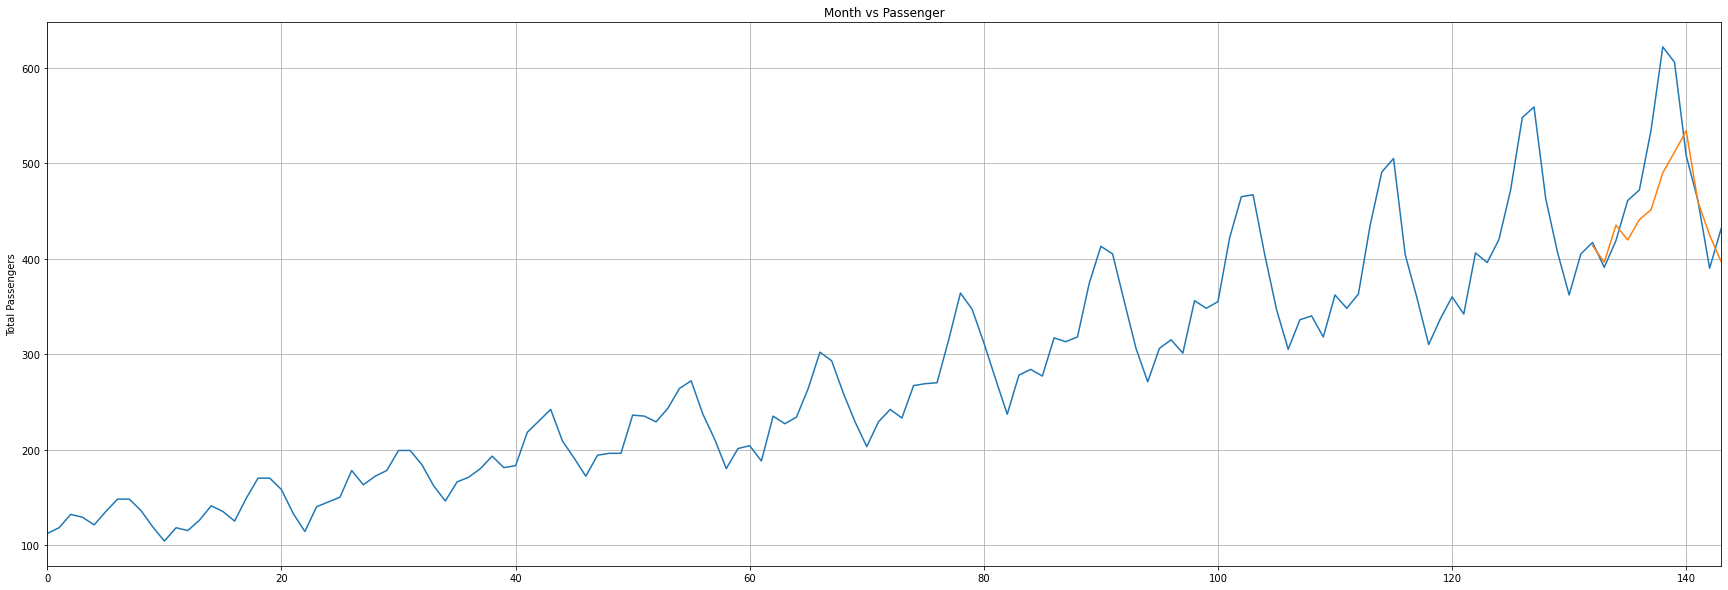

In [25]:
plt.figure(figsize=(30,10))

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

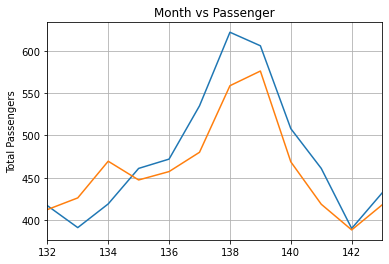

In [26]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

## 실습하기

> 위에서 생성한 모형을 변경하여 layer를 추가하거나 optimizer등의 hyperparameter를 추가하여 더 나은 시계열 예측을 수행하는 모형을 생성해 보시오.